## 1051, 1022 hit maps in different cluster charge region.

e0012r2153: SR pattern on H1022(+x_bwd) and H1051(-x_fwd) are visable on hitmap. injection stopped at the same time when the 1st local daq run.dat complete, it's ideal to compare the hitmaps with and without injection. Some observations from this analysis
- SR on H1051 is related to injection, H1022 not
- SR on H1051 has low cluster charge, H1022 has larger cluster charge

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import tables
import os
import epics_utils
import re

#### what to plot

dhes = ['H1022','H1051']

expnr = 12
runnr = 2153

path = '/data_fast/hye/lab_framework_backup/exp%04irun%04i'%(expnr,runnr)
h5_file = os.path.join(path, 'clusters-1.h5')

save_to_file = True

hitmaps = {}
hitmap_keys = [
    'all'
    ,'s1' # cluster size =1
    ,'s1_c000c010' # cluster size =1, 0 < charge < 10 
    ,'s1_c010c050' # cluster size =1, 10 < charge < 50
    ,'s1_c050c100'
    ,'s1_c100+' # cluster size =1, charge > 100
    ,'s2'
    ,'s2_c010c050'
    ,'s2_c050c100'
    ,'s2+'
]

debug = False
#######

for dhe in dhes:
    hitmaps[dhe] = {}
    for k in hitmap_keys:
        hitmaps[dhe][k] = np.zeros((768, 250))

clusterdata = tables.open_file(h5_file, mode="r")
dhe_clustertables = {dhe: clusterdata.get_node("/", "%s_cluster" % dhe) for dhe in dhes}

for dhe in dhes:
    print(dhe, len(dhe_clustertables[dhe]))
    #module_type = epics_utils.get_pv("PXD:B:config-"+dhe,"module_type:VALUE:set").get(as_string=True)
    
    for el in dhe_clustertables[dhe].where("""(seed_row >= 0) & (seed_row < 768) & (seed_col >= 0) & (seed_col < 250) & (signal < 1000)""" ):        
        
        ## hit maps
        for key in hitmap_keys:
            if key is 'all':
                hitmaps[dhe][key][el['seed_row'], el['seed_col']] += 1
                continue
            
            if re.search('s\d\+', key) is not None:
                s = int(re.findall('s\d\+', key)[0][1])
                if debug: print('s\d\+',s)
                
                if el['size'] > s:
                    hitmaps[dhe][key][el['seed_row'], el['seed_col']] += 1
            elif re.search('s\d', key) is not None:
                s = int(re.findall('s\d', key)[0][1])
                if debug: print('s\d',s)
                
                if el['size'] == s:
                    hitmaps[dhe][key][el['seed_row'], el['seed_col']] += 1 
                    
                    if re.search('c\d{3}\+', key) is not None:
                        c = int(re.findall('c\d{3}\+', key)[0][1:4])
                        if debug: print('c\d{3}\+',c)
                        if el['signal']>c:
                            hitmaps[dhe][key][el['seed_row'], el['seed_col']] += 1 
                    elif re.search('c\d{3}', key) is not None:
                        c = re.findall('c\d{3}', key)
                        if debug: print('c\d{3}',c)
                        if el['signal'] >= int(c[0][1:]) and el['signal'] >= int(c[1][1:]):
                            hitmaps[dhe][key][el['seed_row'], el['seed_col']] += 1 
            
if save_to_file:
    np.save('hitmaps_clustercharge_region_e%4ir%4i'%(expnr,runnr), hitmaps)

H1022 2417369
H1051 682083


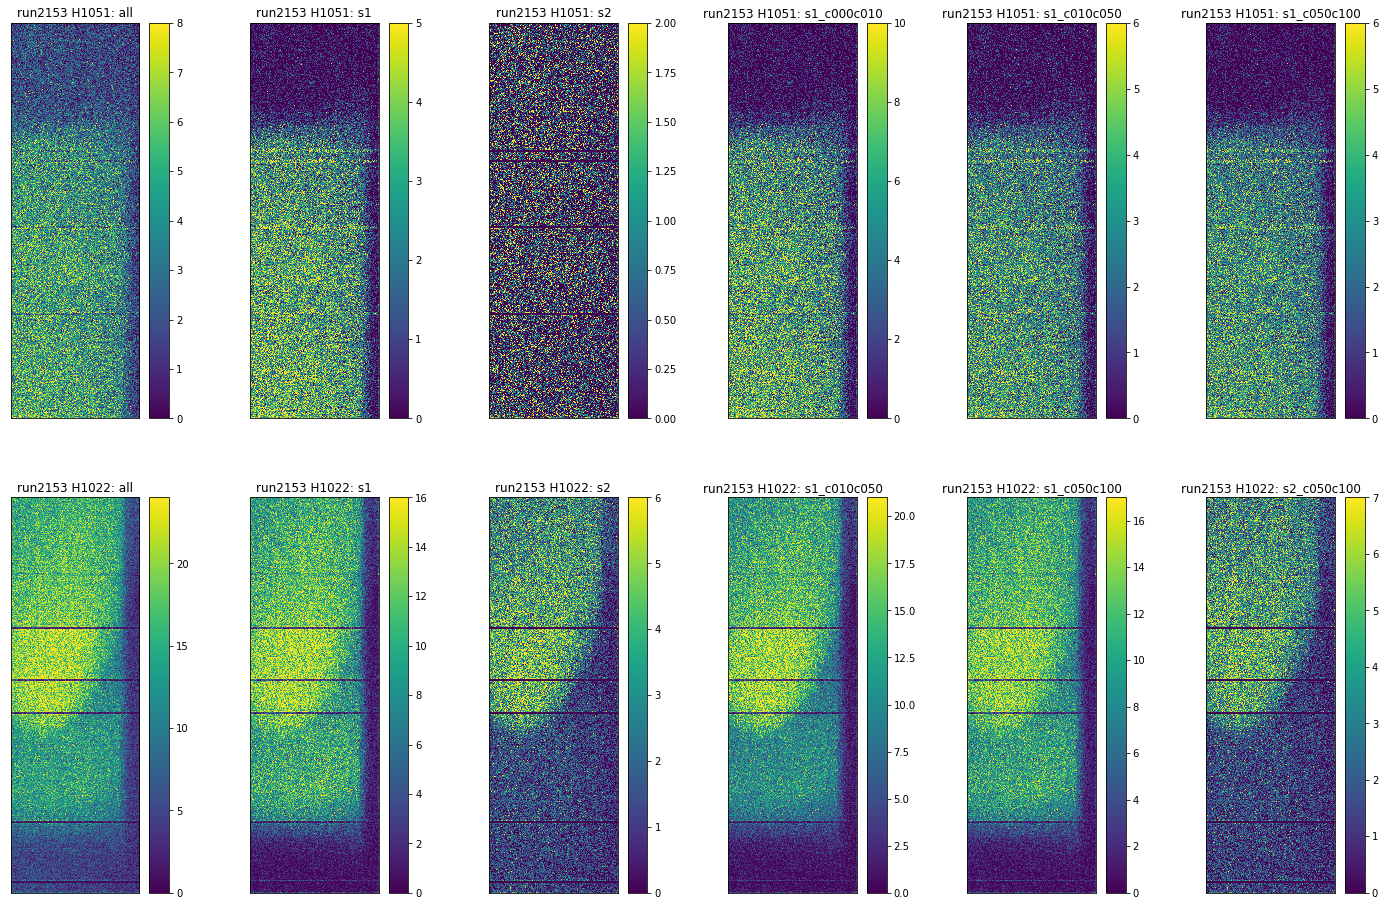

In [11]:
# plot hitmaps

to_plot = {
    'H1051':['all','s1','s2','s1_c000c010','s1_c010c050','s1_c050c100'],
    'H1022':['all','s1','s2','s1_c010c050','s1_c050c100','s2_c050c100']
}

fig, axes = plt.subplots(len(to_plot),np.max([len(to_plot[i]) for i in to_plot.keys()]), figsize=(25,16))

for i,dhe in enumerate(to_plot.keys()):
    if dhe not in hitmaps.keys():
        print(dhe, 'not in', hitmaps.keys())
        continue
        
    for j,key in enumerate(to_plot[dhe]):
        if key not in hitmaps[dhe].keys():
            print(dhe, key, 'not in', hitmaps[dhe].keys())
            continue
            
        ax = axes[i,j]
        data =hitmaps[dhe][key]
        ax.set_title('run%i %s: %s' % (runnr, dhe, key))
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        im = ax.imshow(data,interpolation="none", origin="lower", vmax=np.percentile(data,95))
        fig.colorbar(im, ax=ax)